Longstaff-Shwartz Monte Carlo (LSMC) for American Options pricing:

1) Simulate multiple paths for underlying asset using Monte Carlo \\
2) Calculate payoff of immediate exercise at each time \\
3) Regress future payoffs on the current stock price to estimate the continuation value \\
4) Compare continuation value with immediate exercise payoff and choose maximum at each step \\
5) Use backward induction to calculate the option price at the initial timestep


In [ ]:
# Import Packages ex
! pip install backtesting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Import finacial data

aapl = yf.Ticker("AAPL")
AAPL = aapl.history(start="2016-06-02", end="2024-06-07")

AAPL

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-02 00:00:00-04:00,22.336000,22.390924,22.114012,22.363462,160766400,0.0,0.0
2016-06-03 00:00:00-04:00,22.379489,22.489337,22.301678,22.409239,114019600,0.0,0.0
2016-06-06 00:00:00-04:00,22.425257,23.317782,22.324563,22.571722,93170000,0.0,0.0
2016-06-07 00:00:00-04:00,22.713607,22.855496,22.647240,22.663260,89638000,0.0,0.0
2016-06-08 00:00:00-04:00,22.660969,22.784549,22.583160,22.642662,83392400,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-31 00:00:00-04:00,190.798749,191.924969,189.273875,191.606033,75158300,0.0,0.0
2024-06-03 00:00:00-04:00,192.253831,194.336842,191.875114,193.380051,50080500,0.0,0.0
2024-06-04 00:00:00-04:00,193.988012,194.665742,192.383404,193.698990,47471400,0.0,0.0


In [ ]:
# Import option data from yfinance

import yfinance as yf
import pandas as pd
from IPython.display import display

# Define the ticker symbol
ticker_symbol = "AAPL"
aapl = yf.Ticker(ticker_symbol)

# Get current stock price
current_price = aapl.history(period="1d")["Close"].iloc[-1]
print(f"\nAAPL Current Price: {current_price:.2f}")

# Get available options expiration dates
expirations = aapl.options

# Retrieve options data for multiple expiration dates
all_options = []
num_strikes = 12  # Number of strikes to keep per expiration (6 ITM + 1 ATM + 5 OTM)

# Limit to first 5 expirations to avoid excessive requests
for expiry in expirations[:5]:
    option_chain = aapl.option_chain(expiry)

    # Get calls and puts data
    calls = option_chain.calls
    puts = option_chain.puts

    # Add expiration column for reference
    calls["expiration"] = expiry
    puts["expiration"] = expiry

    # Label calls and puts
    calls["type"] = "call"
    puts["type"] = "put"

    # Combine calls and puts
    options = pd.concat([calls, puts])

    # Sort by strike price
    options = options.sort_values(by="strike").reset_index(drop=True)  # Ensure a clean numeric index

    # Find the closest ATM strike
    atm_index = (options["strike"] - current_price).abs().argsort().iloc[0]  # Get index of the ATM strike

    # Define ITM and OTM boundaries safely
    lower_bound = max(0, atm_index - (num_strikes // 2))  # ITM strikes
    upper_bound = min(len(options) - 1, atm_index + (num_strikes // 2))  # OTM strikes

    # Filter options using `.iloc[]` for numeric indexing
    filtered_options = options.iloc[lower_bound:upper_bound+1]

    # Append filtered options to final list
    all_options.append(filtered_options)

# Combine into a single DataFrame
options_df = pd.concat(all_options)

# Ensure we have multiple expiration dates
if len(options_df["expiration"].unique()) > 1:
    print("\n✅ Multiple Expirations Included")
else:
    print("\n⚠️ Warning: Only One Expiration Found – Check Filtering!")

# Sort by expiration date and strike price for better readability
options_df = options_df.sort_values(by=["expiration", "strike"]).reset_index(drop=True)

# Select relevant columns for display
columns_to_display = [
    "contractSymbol", "expiration", "strike", "lastPrice", "bid", "ask", "volume",
    "openInterest", "impliedVolatility", "type"
]

# Create a new DataFrame with empty rows separating expiration dates and custom index labels
options_display = []
previous_expiration = None
expiration_count = 2  # Expiration label counter
index_labels = []  # Custom index labels

for _, row in options_df.iterrows():
    if previous_expiration is not None and row["expiration"] != previous_expiration:
        blank_row = pd.Series([""] * len(columns_to_display), index=columns_to_display)  # Truly blank row
        options_display.append(blank_row)  # Add separator row
        index_labels.append(f"Expiration {expiration_count}")  # Label the blank row
        expiration_count += 1  # Increment expiration counter

    options_display.append(row)
    index_labels.append("")  # Empty label for normal rows
    previous_expiration = row["expiration"]

# Convert list back to a DataFrame with custom index labels
options_display_df = pd.DataFrame(options_display)

# Set the custom index
options_display_df.index = index_labels

# Display the cleaned options chain
print("\n✅ AAPL Options Chain (Multiple Expirations, Balanced ATM Strikes):")
display(options_display_df[columns_to_display].head(30))  # Show a reasonable subset



AAPL Current Price: 212.02

✅ Multiple Expirations Included

✅ AAPL Options Chain (Multiple Expirations, Balanced ATM Strikes):


,contractSymbol,expiration,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,type
,AAPL250321P00205000,2025-03-21,205.0,0.62,0.6,0.61,6951.0,14687.0,0.327155,put
,AAPL250321C00205000,2025-03-21,205.0,9.5,9.4,9.5,592.0,8187.0,0.594975,call
,AAPL250321C00207500,2025-03-21,207.5,7.35,7.2,7.3,365.0,1785.0,0.527837,call
,AAPL250321P00207500,2025-03-21,207.5,0.98,0.96,0.98,9924.0,5800.0,0.303474,put
,AAPL250321P00210000,2025-03-21,210.0,1.56,1.54,1.57,21485.0,39289.0,0.279304,put
,AAPL250321C00210000,2025-03-21,210.0,5.3,5.4,5.5,2482.0,21861.0,0.499273,call
,AAPL250321C00212500,2025-03-21,212.5,3.75,3.75,3.8,7813.0,5872.0,0.453619,call
,AAPL250321P00212500,2025-03-21,212.5,2.42,2.39,2.42,19059.0,7252.0,0.246834,put
,AAPL250321P00215000,2025-03-21,215.0,3.55,3.55,3.65,7019.0,12650.0,0.202401,put
,AAPL250321C00215000,2025-03-21,215.0,2.43,2.4,2.42,29951.0,10903.0,0.416021,call


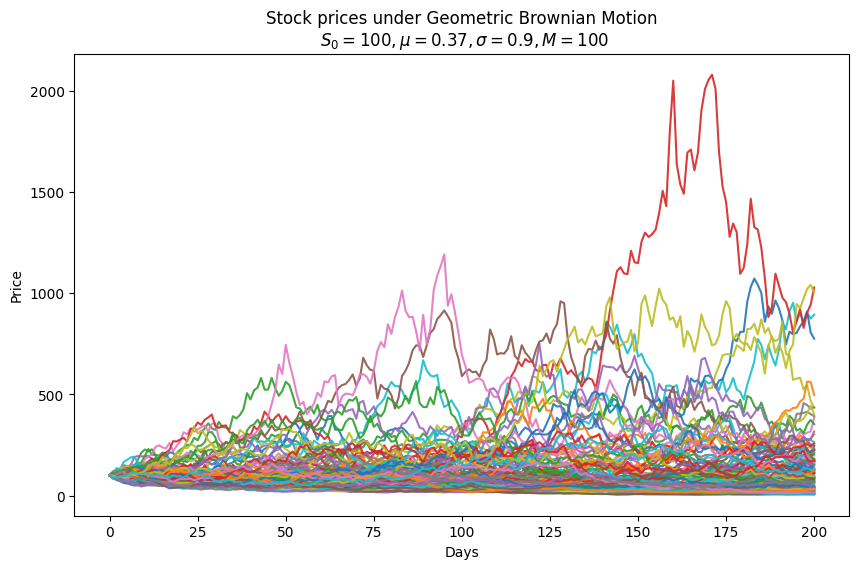

In [ ]:
# Simulate multiple paths for underlying asset using Monte Carlo

mu = 0.37  # Drift coefficient
T = 2  # Time in years
n = 100 * T  # Number of steps (252 trading days per year)
M = 100  # Number of simulations
S0 = 100  # Initial stock price
sigma = 0.9  # Volatility
dt = T / n  # Step/period length

# Simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

# Include array of 1's for the initial price
St = np.vstack([np.ones(M), St])

# Multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0)
St = S0 * St.cumprod(axis=0)

# Convert to pandas DataFrame
data = pd.DataFrame(St, columns=[f'Stock price sim {i+1}' for i in range(M)])

# Plotting all simulation paths
plt.figure(figsize=(10, 6))

# Plot individual simulation stock prices
for i in range(M):
    plt.plot(data.index, data[f'Stock price sim {i+1}'], label=f'Simulation {i+1}', alpha=0.9)

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"Stock prices under Geometric Brownian Motion\n $S_0 = {S0}, \mu = {mu}, \sigma = {sigma}, M = {M}$")
plt.show()


In [ ]:
# Evaluate price of American Put Option

K = 100 # strike price
r = 0.05 # risk-free rate

# Initialize payoff values (V) as exercise value of option at maturity
V = np.maximum(K - St[-1, :], 0)


for t in range(n-1, 0, -1): #One step back until t=0

  # Value of immediate exercise for each simulation at time period t
  payoff_vals = np.maximum(K - St[t, :], 0)
  payoff_vals = np.nan_to_num(payoff_vals, nan=0.0)  # Replace NaNs with 0

  # Find C_t for for each simulation at time period t
  ITM = payoff_vals > 0  # Consider only paths where the option is In The Money

  if np.sum(ITM) == 0:
        continue  # Skip following steps if no paths are In The Money

  # Use linear regression to estimate the continuation values of ITM simulations
  X = St[t, ITM].reshape(-1, 1)  # Stock prices at time period t
  Y = V[ITM] * np.exp(-r * dt)  # Discounted future option values

  model = LinearRegression().fit(X, Y)  # Fit regression model
  continuation_values = model.predict(X)  # Predicted continuation values

  # Compare and decide whether to exercise option
  exercise_value = payoff_vals[ITM]
  exercise_now = exercise_value > continuation_values

  # Update payoff values: If exercised, take immediate exercise value; otherwise, continue holding
  V[ITM] = np.where(exercise_now, exercise_value, payoff_vals[ITM] * np.exp(-r * dt))

option_price = np.mean(V) # Calculate mean option price
print(f"\nAmerican Put Option Price (LSMC): {option_price:.4f}")



American Put Option Price (LSMC): 5.8229


In [ ]:
# Evaluate price of American Call Option

K = 100 # strike price
r = 0.05 # risk-free rate

# Initialize payoff values (V) as exercise value of option at maturity
V = np.maximum(St[-1, :] - K, 0)


for t in range(n-1, 0, -1): #One step back until t=0

  # Value of immediate exercise for each simulation at time period t
  payoff_vals = np.maximum(St[t, :] - K, 0)
  payoff_vals = np.nan_to_num(payoff_vals, nan=0.0)  # Replace NaNs with 0

  # Find C_t for for each simulation at time period t
  ITM = payoff_vals > 0  # Consider only paths where the option is In The Money

  if np.sum(ITM) == 0:
        continue  # Skip following steps if no paths are In The Money

  # Use linear regression to estimate the continuation values of ITM simulations
  X = St[t, ITM].reshape(-1, 1)  # Stock prices at time period t
  Y = V[ITM] * np.exp(-r * dt)  # Discounted future option values

  model = LinearRegression().fit(X, Y)  # Fit regression model
  continuation_values = model.predict(X)  # Predicted continuation values

  # Compare and decide whether to exercise option
  exercise_value = payoff_vals[ITM]
  exercise_now = exercise_value > continuation_values

  # Update payoff values: If exercised, take immediate exercise value; otherwise, continue holding
  V[ITM] = np.where(exercise_now, exercise_value, payoff_vals[ITM] * np.exp(-r * dt))

option_price = np.mean(V) # Calculate mean option price
print(f"\nAmerican Call Option Price (LSMC): {option_price:.4f}")


American Call Option Price (LSMC): 6.6688
